In [1]:
from model import Densenet, Inceptionv3, ResNet, VGG, SimpleCNN, Efficientnet, ResNeSt, Ensemble,SeResNet, Deeplabv3
from model import prunnableResNet
from model.layer.prunableLayer import prunnableConv2D,prunnableLinear
from utils import CovidCTDataset,metrics, SimCLR_loss, LabelSmoothSoftmaxCE
from utils import autoaugment as auto
from torch.utils.data import DataLoader
import argparse
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import torch.nn as nn
import os
import random
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score

from collections import OrderedDict
import matplotlib.pyplot as plt
import easydict

import gc

MODEL_DICT = {
    'densenet121': Densenet.densenet121,
    'densenet161': Densenet.densenet161,
    'densenet169': Densenet.densenet169,
    'densenet201': Densenet.densenet201,
    'resnet18': ResNet.resnet18,
    'resnet50': ResNet.resnet50,
    'resnet101': ResNet.resnet101,
    'resnet152': ResNet.resnet152,
    'seresnet50': SeResNet.se_resnet50,
    'seresnet101': SeResNet.se_resnet101,
    'seresnet152': SeResNet.se_resnet152,
    'resnext101': ResNet.resnext101_32x8d,
    'resnest50': ResNeSt.resnest50,
    'resnest200': ResNeSt.resnest200,
    'wide_resnet101': ResNet.wide_resnet101_2,
    'wide_resnet50': ResNet.wide_resnet50_2,
    'vgg16': VGG.vgg16,
    'CNN': SimpleCNN.CNN,
    'Linear': SimpleCNN.Linear,
    'SimpleCNN': SimpleCNN.SimpleCNN,
    'efficientnet-b7': Efficientnet.efficientnetb7,
    'efficientnet-b1': Efficientnet.efficientnetb1,
    'efficientnet-b0': Efficientnet.efficientnetb0
}

PRUNNABLE_MODEL_DICT={
    'resnet18':prunnableResNet.resnet18,
    'resnet50':prunnableResNet.resnet50,
    'resnet101':prunnableResNet.resnet101,
    'resnet152':prunnableResNet.resnet152
}

def train(model, train_loader, optimizer, PRINT_INTERVAL, epoch, args, device):
    model.train()
    # LOSS_FUNC = LabelSmoothSoftmaxCE()
    LOSS_FUNC = nn.CrossEntropyLoss()
    for index, batch in enumerate(tqdm(train_loader)):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        optimizer.zero_grad()
        loss = LOSS_FUNC(output, label)
        loss.backward()
        optimizer.step()
        if (index + 1) % PRINT_INTERVAL == 0:
            tqdm.write('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
                       % (epoch + 1, args.epoch, index + 1, len(train_loader), loss.item()))

def test(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            output = model(img)
            _, preds = torch.max(output, 1)
            avg_val_loss += F.cross_entropy(output, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(output, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def test_mask(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            cls_pred, mask_pred = model(img)
            _, preds = torch.max(cls_pred, 1)

            avg_val_loss += F.cross_entropy(cls_pred, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(cls_pred, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def convertPaWeights2NonP(pretrained_state_dict):
  nonpStateDict=OrderedDict()
  for k, v in pretrained_state_dict.items():
    nonpStateDict[k[7:]]=v
  return nonpStateDict

def convertStateDict2Prunnable(state_dict):
    prunedStateDict=OrderedDict()
    for k, v in state_dict.items():
        if 'conv' in k or 'downsample.0' in k:
            p=k.find('.weight')
            k=k[:p]+'.conv'+k[p:]
        elif 'fc' in k:
            p=k.find('fc')
            k=k[:p+3]+'linear.'+k[p+3:]
            

        prunedStateDict[k]=v
    return prunedStateDict

models_config = (
    # model name, model path, weight, data_parallel
    ('resnet152', 'resnet152_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('resnet152', 'resnet152_4_4_crop_480_b16w1.2_pretrained.pt', 1, True),
    ('resnext101', 'resnext101_4_4_crop_480_pretrained.pt', 1, True),
    ('densenet169', 'densenet169-480-moco-soft-COVID.pt', 1, True),
    ('densenet169', 'densenet169_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('densenet169', 'densenet169_soft_480_pretrained.pt', 1, True),
)

args = easydict.EasyDict({
    'model_name':'resnet50',
    'checkpoint_path':'./checkpoint/CT',
    'batch_size':16,
    'lr':1e-4,
    'epoch':50,
    'root_dir':'./COVID-CT/Images-processed',

    'train_COV':'./COVID-CT/Data-split/COVID/trainCT_COVID.txt',
    'train_NonCOV':'./COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',

    'val_COV':'./COVID-CT/Data-split/COVID/valCT_COVID.txt',
    'val_NonCOV':'./COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',

    'test_COV':'./COVID-CT/Data-split/COVID/testCT_COVID.txt',
    'test_NonCOV':'./COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',

    'pretrained':True,
    'save_name':'resnet50_pretrained.pt'
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device {}".format(device))
# Create checkpoint file
save_path = os.path.join(args.checkpoint_path, args.model_name)
if os.path.exists(save_path) == False:
    os.makedirs(save_path)

normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                    std=[0.33165374, 0.33165374, 0.33165374])
test_trans = transforms.Compose(
                                [
                                transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                normalize
                                ]
                            )
trainset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.train_COV,
                            txt_NonCOVID=args.train_NonCOV,
                            transform=transforms.Compose(
                                [transforms.RandomResizedCrop((480,480),scale=(0.8,1.2)),
                                    transforms.RandomHorizontalFlip(),
                                    auto.ImageNetPolicy(),
                                    transforms.ToTensor(),
                                    normalize
                                    ]
                            ))
valset = CovidCTDataset(root_dir=args.root_dir,
                        txt_COVID=args.val_COV,
                        txt_NonCOVID=args.val_NonCOV,
                            transform=test_trans
                            )

testset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.test_COV,
                            txt_NonCOVID=args.test_NonCOV,
                            transform=test_trans
                            )

train_loader = DataLoader(trainset,
                            batch_size=args.batch_size,
                            num_workers=8,
                            shuffle=True)
val_loader = DataLoader(valset, batch_size=args.batch_size)
test_loader = DataLoader(testset,batch_size=args.batch_size)

PRINT_INTERVAL = 10
nb_classes = 2
seg_num_class = 2
print(args.model_name,trainset.classes)

model = PRUNNABLE_MODEL_DICT[args.model_name](num_classes=nb_classes, pretrained=args.pretrained)

accs = []
save = os.path.join(save_path,'{}'.format(args.save_name))

print('...........Testing..........')
pretrained_state_dict=torch.load(save, map_location=torch.device('cpu'))
pretrained_state_dict=convertPaWeights2NonP(pretrained_state_dict)
model.load_state_dict(convertStateDict2Prunnable(pretrained_state_dict))

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model).to(device)
elif torch.cuda.device_count() == 1:
    model.to(device)
elif torch.cuda.is_available():
    print("GPU detected but cannot use")


Device cuda
resnet50 ['CT_COVID', 'CT_NonCOVID']
...........Testing..........


In [2]:
cntConv=0
cntDense=0

for m in model.modules():
    if isinstance(m, prunnableConv2D):
        cntConv+=1
    elif isinstance(m, prunnableLinear):
        cntDense+=1
print("In total %d conv, %d dense"%(cntConv,cntDense))

In total 53 conv, 1 dense


In [6]:

ratios=[i/100 for i in range(0,91,10)]
yconvACC,yconvFN=[],[]
ydenseACC,ydenseFN=[],[]
cntConv=-1
for m in model.modules():
    yACC=[]
    yFN=[]
    if isinstance(m, (prunnableConv2D,prunnableLinear)):
        if isinstance(m,prunnableConv2D):
            cntConv+=1
            if cntConv%10!=0:continue
        print(m) 
        for r in ratios:
            m.setPruneRatio(r)
            print('prune ratio:%f'%r)
            AUC, precision, recall, f1, acc, mean_loss = test(model, 2, test_loader, device)
            print('Precision {}\tRecall {}\nF1 {}\nAUC {}\tAcc {}\tMean Loss {}'.format(precision, recall, f1, AUC, acc,
                                                                            mean_loss))
            yACC.append(acc.numpy().tolist())
            yFN.append(recall[1])
            m.resetPruneRatio()
    if isinstance(m,prunnableConv2D):
        yconvACC.append(yACC.copy())
        yconvFN.append(yFN.copy())
    elif isinstance(m,prunnableLinear):
        ydenseACC.append(yACC.copy())
        ydenseFN.append(yFN.copy())

  0%|          | 0/13 [00:00<?, ?it/s]

prunnableConv2D(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[77., 21.],
        [40., 65.]])
Precision [0.78571427 0.61904764]	Recall [0.6581197  0.75581396]
F1 [0.7162791 0.6806283]
AUC 0.7430515063168125	Acc 0.6995074152946472	Mean Loss 0.650707240288074
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[82., 16.],
        [52., 53.]])
Precision [0.8367347  0.50476193]	Recall [0.6119403  0.76811594]
F1 [0.7068966 0.6091954]
AUC 0.7498542274052478	Acc 0.6650246381759644	Mean Loss 0.6395644728954022
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[70., 28.],
        [33., 72.]])
Precision [0.71428573 0.6857143 ]	Recall [0.6796116 0.72     ]
F1 [0.69651747 0.70243907]
AUC 0.7334305150631683	Acc 0.6995074152946472	Mean Loss 0.6456993245161496
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [93., 12.]])
Precision [0.97959185 0.11428571]	Recall [0.50793654 0.85714287]
F1 [0.6689896  0.20168068]
AUC 0.7247813411078717	Acc 0.5320196747779846	Mean Loss 0.7056529315618368
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[90.,  8.],
        [67., 38.]])
Precision [0.9183673  0.36190477]	Recall [0.5732484  0.82608694]
F1 [0.7058823 0.5033112]
AUC 0.7766763848396502	Acc 0.6305418610572815	Mean Loss 0.6506233467505528
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [102.,   3.]])
Precision [1.         0.02857143]	Recall [0.49 1.  ]
F1 [0.6577181  0.05555555]
AUC 0.7620991253644315	Acc 0.49753695726394653	Mean Loss 0.7061052459936876
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [103.,   2.]])
Precision [0.9897959  0.01904762]	Recall [0.485     0.6666667]
F1 [0.65100676 0.03703704]
AUC 0.7707482993197279	Acc 0.4876847267150879	Mean Loss 0.6765875839270078
prune ratio:0.800000


100%|██████████| 13/13 [00:17<00:00,  1.08s/it]
/home/z7zeng/ECE228-final/COVID-Z/utils/metrics.py:25: RuntimeWarning: invalid value encountered in true_divide
  return (2*precision*recall)/(precision+recall)
  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [105.,   0.]])
Precision [0.9897959 0.       ]	Recall [0.48019803 0.        ]
F1 [0.64666665        nan]
AUC 0.8124392614188531	Acc 0.47783252596855164	Mean Loss 0.691039727284358
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [103.,   2.]])
Precision [1.         0.01904762]	Recall [0.48756218 1.        ]
F1 [0.6555184  0.03738318]
AUC 0.8012633624878523	Acc 0.4926108419895172	Mean Loss 0.6781329535520992
prunnableConv2D(
  (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[86., 12.],
        [61., 44.]])
Precision [0.877551   0.41904762]	Recall [0.585034   0.78571427]
F1 [0.70204085 0.5465839 ]
AUC 0.7569484936831876	Acc 0.6403940916061401	Mean Loss 0.6508560432837559
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[79., 19.],
        [53., 52.]])
Precision [0.8061224 0.4952381]	Recall [0.5984849  0.73239434]
F1 [0.6869565 0.5909091]
AUC 0.7542274052478134	Acc 0.6453201770782471	Mean Loss 0.6342980655340048
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[69., 29.],
        [30., 75.]])
Precision [0.70408165 0.71428573]	Recall [0.6969697  0.72115386]
F1 [0.70050764 0.71770334]
AUC 0.7429543245869776	Acc 0.7093595862388611	Mean Loss 0.6261912125807542
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[62., 36.],
        [24., 81.]])
Precision [0.63265306 0.7714286 ]	Recall [0.7209302 0.6923077]
F1 [0.673913  0.7297298]
AUC 0.7620019436345968	Acc 0.7044335007667542	Mean Loss 0.6190340610650868
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[48., 50.],
        [23., 82.]])
Precision [0.48979592 0.7809524 ]	Recall [0.6760563 0.6212121]
F1 [0.56804734 0.69198316]
AUC 0.7504373177842566	Acc 0.6403940916061401	Mean Loss 0.6326532501440782
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[54., 44.],
        [21., 84.]])
Precision [0.5510204 0.8      ]	Recall [0.72    0.65625]
F1 [0.6242774 0.7210301]
AUC 0.765597667638484	Acc 0.6798029541969299	Mean Loss 0.6224656540613908
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[67., 31.],
        [23., 82.]])
Precision [0.68367344 0.7809524 ]	Recall [0.74444443 0.7256637 ]
F1 [0.712766  0.7522936]
AUC 0.7919339164237125	Acc 0.7339901328086853	Mean Loss 0.611720908146638
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[61., 37.],
        [21., 84.]])
Precision [0.622449 0.8     ]	Recall [0.74390244 0.6942149 ]
F1 [0.67777777 0.7433629 ]
AUC 0.7780369290573372	Acc 0.7142857313156128	Mean Loss 0.6182078306491559
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[59., 39.],
        [25., 80.]])
Precision [0.6020408 0.7619048]	Recall [0.70238096 0.6722689 ]
F1 [0.64835167 0.71428573]
AUC 0.7434402332361516	Acc 0.6847290396690369	Mean Loss 0.6314756365922781
prunnableConv2D(
  (conv): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[94.,  4.],
        [68., 37.]])
Precision [0.9591837  0.35238096]	Recall [0.5802469 0.902439 ]
F1 [0.72307694 0.5068493 ]
AUC 0.7494655004859085	Acc 0.6453201770782471	Mean Loss 0.6928669019387318
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[94.,  4.],
        [73., 32.]])
Precision [0.9591837  0.30476192]	Recall [0.56287426 0.8888889 ]
F1 [0.709434  0.4539007]
AUC 0.7466472303206997	Acc 0.6206896305084229	Mean Loss 0.6929069310426712
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[95.,  3.],
        [79., 26.]])
Precision [0.96938777 0.24761905]	Recall [0.545977  0.8965517]
F1 [0.6985294 0.3880597]
AUC 0.7537414965986396	Acc 0.5960590839385986	Mean Loss 0.6944576742557378
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [84., 21.]])
Precision [0.9897959 0.2      ]	Recall [0.5359116  0.95454544]
F1 [0.6953405  0.33070865]
AUC 0.7509232264334306	Acc 0.5812807679176331	Mean Loss 0.7053998846274155
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[95.,  3.],
        [74., 31.]])
Precision [0.96938777 0.2952381 ]	Recall [0.56213015 0.9117647 ]
F1 [0.7116105 0.4460432]
AUC 0.7468415937803694	Acc 0.6206896305084229	Mean Loss 0.6844541017825787
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[93.,  5.],
        [74., 31.]])
Precision [0.9489796 0.2952381]	Recall [0.55688626 0.8611111 ]
F1 [0.7018869  0.43971637]
AUC 0.7434402332361516	Acc 0.610837459564209	Mean Loss 0.6809865626005026
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [81., 24.]])
Precision [0.9285714  0.22857143]	Recall [0.5290698 0.7741935]
F1 [0.6740741 0.3529412]
AUC 0.7467444120505345	Acc 0.5665024518966675	Mean Loss 0.6745777198901544
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[92.,  6.],
        [80., 25.]])
Precision [0.93877554 0.23809524]	Recall [0.53488374 0.8064516 ]
F1 [0.6814815  0.36764708]
AUC 0.7438289601554908	Acc 0.5763546824455261	Mean Loss 0.6735689112773309
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[94.,  4.],
        [84., 21.]])
Precision [0.9591837 0.2      ]	Recall [0.5280899 0.84     ]
F1 [0.6811594  0.32307693]
AUC 0.7472303206997085	Acc 0.5665024518966675	Mean Loss 0.6782578505002536
prunnableConv2D(
  (conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [83., 22.]])
Precision [0.97959185 0.20952381]	Recall [0.5363129 0.9166667]
F1 [0.69314086 0.34108526]
AUC 0.7458697764820214	Acc 0.5812807679176331	Mean Loss 0.7246338954338661
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [85., 20.]])
Precision [0.9897959 0.1904762]	Recall [0.53296703 0.95238096]
F1 [0.6928571  0.31746033]
AUC 0.7468415937803693	Acc 0.5763546824455261	Mean Loss 0.7295778657381351
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [89., 16.]])
Precision [0.9897959  0.15238096]	Recall [0.52150536 0.9411765 ]
F1 [0.68309855 0.26229507]
AUC 0.7513119533527697	Acc 0.5566502213478088	Mean Loss 0.7334322069699948
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [86., 19.]])
Precision [0.9897959  0.18095239]	Recall [0.5300546 0.95     ]
F1 [0.6903915 0.304    ]
AUC 0.751603498542274	Acc 0.5714285969734192	Mean Loss 0.7216849980446008
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [98.,  7.]])
Precision [0.9897959  0.06666667]	Recall [0.4974359 0.875    ]
F1 [0.66211605 0.12389381]
AUC 0.7489795918367348	Acc 0.5123152732849121	Mean Loss 0.748028169457729
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [103.,   2.]])
Precision [0.9897959  0.01904762]	Recall [0.485     0.6666667]
F1 [0.65100676 0.03703704]
AUC 0.7470359572400389	Acc 0.4876847267150879	Mean Loss 0.7867536063377674
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [104.,   1.]])
Precision [0.9897959  0.00952381]	Recall [0.48258707 0.5       ]
F1 [0.6488294  0.01869159]
AUC 0.7597667638483965	Acc 0.48275861144065857	Mean Loss 0.7680348272507007
prune ratio:0.800000


100%|██████████| 13/13 [00:17<00:00,  1.15s/it]
/home/z7zeng/ECE228-final/COVID-Z/utils/metrics.py:25: RuntimeWarning: invalid value encountered in true_divide
  return (2*precision*recall)/(precision+recall)
  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [105.,   0.]])
Precision [0.9897959 0.       ]	Recall [0.48019803 0.        ]
F1 [0.64666665        nan]
AUC 0.7576287657920312	Acc 0.47783252596855164	Mean Loss 0.77822015950313
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.7597667638483967	Acc 0.48275861144065857	Mean Loss 0.8052929273018472
prunnableConv2D(
  (conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [76., 29.]])
Precision [0.9897959 0.2761905]	Recall [0.5606936  0.96666664]
F1 [0.7158671  0.42962965]
AUC 0.7436345966958211	Acc 0.6206896305084229	Mean Loss 0.721572947043639
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [86., 19.]])
Precision [0.97959185 0.18095239]	Recall [0.52747256 0.9047619 ]
F1 [0.68571436 0.30158728]
AUC 0.7443148688046648	Acc 0.5665024518966675	Mean Loss 0.7311493525138268
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [90., 15.]])
Precision [0.9897959  0.14285715]	Recall [0.5187166 0.9375   ]
F1 [0.6807018 0.2479339]
AUC 0.7430515063168124	Acc 0.5517241358757019	Mean Loss 0.7492471211231673
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [94., 11.]])
Precision [0.9897959  0.10476191]	Recall [0.5078534 0.9166667]
F1 [0.6712803  0.18803419]
AUC 0.7412050534499514	Acc 0.5320196747779846	Mean Loss 0.7533133213336652
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [103.,   2.]])
Precision [0.9897959  0.01904762]	Recall [0.485     0.6666667]
F1 [0.65100676 0.03703704]
AUC 0.7387755102040815	Acc 0.4876847267150879	Mean Loss 0.7823678667728718
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [104.,   1.]])
Precision [0.9897959  0.00952381]	Recall [0.48258707 0.5       ]
F1 [0.6488294  0.01869159]
AUC 0.7389698736637512	Acc 0.48275861144065857	Mean Loss 0.8025014136846248
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.7350826044703596	Acc 0.48275861144065857	Mean Loss 0.8229043632745743
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.7352769679300292	Acc 0.48275861144065857	Mean Loss 0.8849753336264536
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.7343051506316813	Acc 0.48275861144065857	Mean Loss 0.9252995722568951
prunnableConv2D(
  (conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[89.,  9.],
        [62., 43.]])
Precision [0.90816325 0.40952381]	Recall [0.589404  0.8269231]
F1 [0.7148595 0.5477707]
AUC 0.7465500485908649	Acc 0.6502463221549988	Mean Loss 0.675517969406568
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[82., 16.],
        [56., 49.]])
Precision [0.8367347  0.46666667]	Recall [0.5942029  0.75384617]
F1 [0.6949153  0.57647055]
AUC 0.7453838678328474	Acc 0.6453201770782471	Mean Loss 0.6482581817186795
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[83., 15.],
        [57., 48.]])
Precision [0.8469388  0.45714286]	Recall [0.5928571 0.7619048]
F1 [0.69747895 0.57142854]
AUC 0.7451895043731779	Acc 0.6453201770782471	Mean Loss 0.6488737372251658
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[87., 11.],
        [60., 45.]])
Precision [0.8877551  0.42857143]	Recall [0.59183675 0.8035714 ]
F1 [0.71020406 0.5590062 ]
AUC 0.745578231292517	Acc 0.6502463221549988	Mean Loss 0.6626576643723708
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[87., 11.],
        [60., 45.]])
Precision [0.8877551  0.42857143]	Recall [0.59183675 0.8035714 ]
F1 [0.71020406 0.5590062 ]
AUC 0.7454810495626821	Acc 0.6502463221549988	Mean Loss 0.6574020729615138
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[89.,  9.],
        [61., 44.]])
Precision [0.90816325 0.41904762]	Recall [0.5933333 0.8301887]
F1 [0.7177419 0.556962 ]
AUC 0.7451895043731779	Acc 0.6551724076271057	Mean Loss 0.6647388430742117
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[86., 12.],
        [60., 45.]])
Precision [0.877551   0.42857143]	Recall [0.5890411 0.7894737]
F1 [0.7049181 0.5555556]
AUC 0.7442176870748299	Acc 0.6453201770782471	Mean Loss 0.6550711393356323
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[89.,  9.],
        [62., 43.]])
Precision [0.90816325 0.40952381]	Recall [0.589404  0.8269231]
F1 [0.7148595 0.5477707]
AUC 0.7444120505344995	Acc 0.6502463221549988	Mean Loss 0.6634239164682534
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[80., 18.],
        [55., 50.]])
Precision [0.81632656 0.47619048]	Recall [0.5925926 0.7352941]
F1 [0.6866953 0.5780347]
AUC 0.745578231292517	Acc 0.6403940916061401	Mean Loss 0.6358933815589318
prunnableLinear(
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[94.,  4.],
        [72., 33.]])
Precision [0.9591837  0.31428573]	Recall [0.56626505 0.8918919 ]
F1 [0.7121212  0.46478876]
AUC 0.7431486880466472	Acc 0.6256157755851746	Mean Loss 0.6936108779448729
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [86., 19.]])
Precision [0.9897959  0.18095239]	Recall [0.5300546 0.95     ]
F1 [0.6903915 0.304    ]
AUC 0.745092322643343	Acc 0.5714285969734192	Mean Loss 0.7044838277193217
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [92., 13.]])
Precision [0.9897959  0.12380952]	Recall [0.5132275 0.9285714]
F1 [0.6759583 0.2184874]
AUC 0.7441205053449952	Acc 0.5418719053268433	Mean Loss 0.7078682230069087
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [104.,   1.]])
Precision [0.9897959  0.00952381]	Recall [0.48258707 0.5       ]
F1 [0.6488294  0.01869159]
AUC 0.748396501457726	Acc 0.48275861144065857	Mean Loss 0.7279928074433254
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[95.,  3.],
        [77., 28.]])
Precision [0.96938777 0.26666668]	Recall [0.5523256 0.9032258]
F1 [0.7037037  0.41176474]
AUC 0.7485908649173955	Acc 0.6059113144874573	Mean Loss 0.665606248837251
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[63., 35.],
        [27., 78.]])
Precision [0.64285713 0.74285716]	Recall [0.7       0.6902655]
F1 [0.67021275 0.7155963 ]
AUC 0.7447035957240038	Acc 0.6945812702178955	Mean Loss 0.6335609922042259
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[88., 10.],
        [60., 45.]])
Precision [0.8979592  0.42857143]	Recall [0.5945946 0.8181818]
F1 [0.7154472 0.5625   ]
AUC 0.7527696793002916	Acc 0.6551724076271057	Mean Loss 0.6574555635452272
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[78., 20.],
        [51., 54.]])
Precision [0.79591835 0.51428574]	Recall [0.60465115 0.7297297 ]
F1 [0.6872247  0.60335195]
AUC 0.7410106899902819	Acc 0.6502463221549988	Mean Loss 0.6656739299113934
prune ratio:0.900000


100%|██████████| 13/13 [00:17<00:00,  1.20s/it]

tensor([[  2.,  96.],
        [  4., 101.]])
Precision [0.02040816 0.96190476]	Recall [0.33333334 0.51269037]
F1 [0.03846154 0.6688742 ]
AUC 0.6804664723032071	Acc 0.5073891878128052	Mean Loss 0.6798084515791672


In [7]:
np.save('yconvACC.npy', yconvACC)
np.save('yconvFN.npy', yconvFN)
np.save('ydenseACC.npy', ydenseACC)
np.save('ydenseFN.npy', ydenseFN)
yconvACC_bak,yconvFN_bak=yconvACC.copy(),yconvFN.copy()
ydenseACC_bak,ydenseFN_bak=ydenseACC.copy(),ydenseFN.copy()

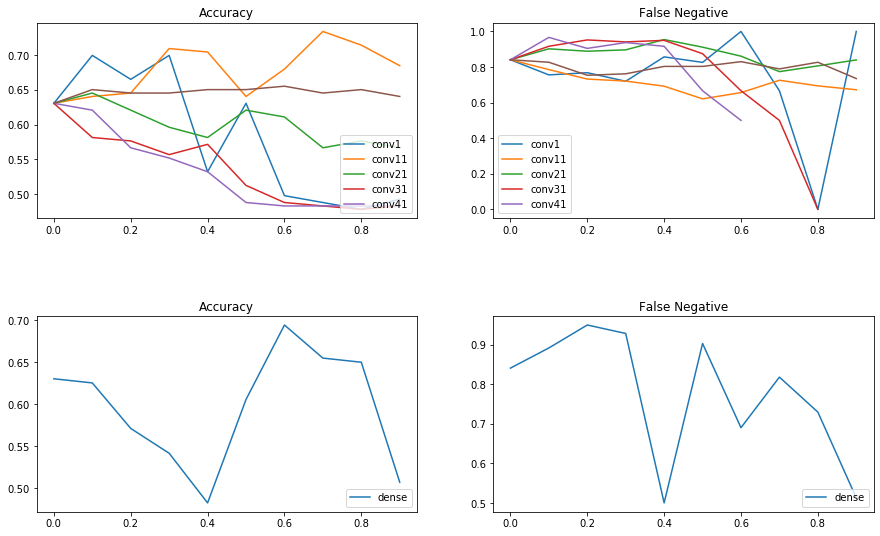

In [17]:

yconvACC,yconvFN=np.load('yconvACC.npy'),np.load('yconvFN.npy')
ydenseACC,ydenseFN=np.load('ydenseACC.npy'),np.load('ydenseFN.npy')

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,2,1)
for yACC in yconvACC:
    plt.plot(ratios, yACC)
plt.title("Accuracy")
plt.legend(["conv"+str(i*10+1) for i in range(5)], loc='lower right')
plt.subplot(2,2,2)
for yFN in yconvFN:
    plt.plot(ratios, yFN)
plt.title("False Negative")
plt.legend(["conv"+str(i*10+1) for i in range(5)], loc='lower left')
plt.subplot(2,2,3)
for yACC in ydenseACC:
    plt.plot(ratios,yACC)
plt.title("Accuracy")
plt.legend(["dense"], loc='lower right')
plt.subplot(2,2,4)
for yFN in ydenseFN:
    plt.plot(ratios,yFN)
plt.title("False Negative")
plt.legend(["dense"], loc='lower right')


plt.show()

# plt.show()